In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

load data

In [2]:
data_eval = pd.read_csv('./data/sales_train_evaluation.csv')
data_train = pd.read_csv('./data/sales_train_validation.csv')
calender = pd.read_csv('./data/calendar.csv')
price = pd.read_csv('./data/sell_prices.csv')
submit = pd.read_csv('./data/sample_submission.csv')

EDA

In [3]:
print(data_train.shape)
print(data_eval.shape)
print(calender.shape)
print(price.shape)
print(submit.shape)

(30490, 1919)
(30490, 1947)
(1969, 14)
(6841121, 4)
(60980, 29)


In [50]:
data_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


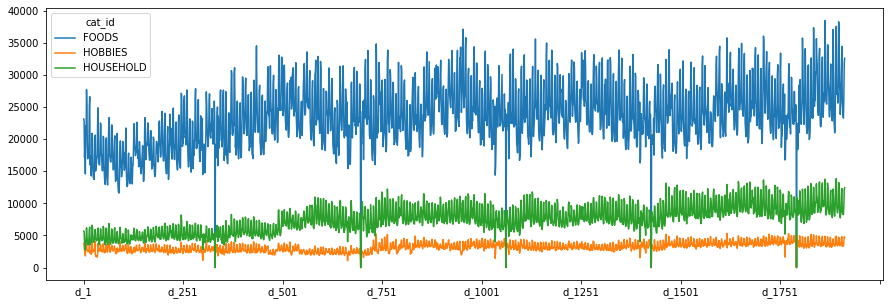

In [89]:
d_cols = [col for col in data_train.columns if 'd_' in col]
data_train.set_index('cat_id')[d_cols].groupby(by=['cat_id']).sum().T.plot(figsize=(15, 5))
# plt.show()
plt.savefig('cat_id.png', format='png')

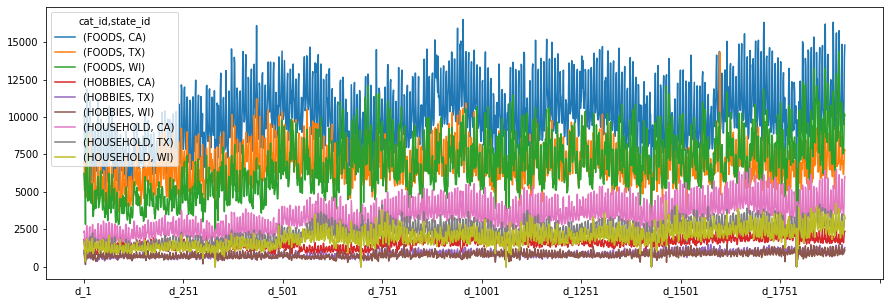

In [90]:
d_cols = [col for col in data_train.columns if 'd_' in col]
data_train.set_index(['cat_id', 'state_id'])[d_cols].groupby(by=['cat_id', 'state_id']).sum().T.plot(figsize=(15, 5))
# plt.show()
plt.savefig('cat_state_id.png', format='png')

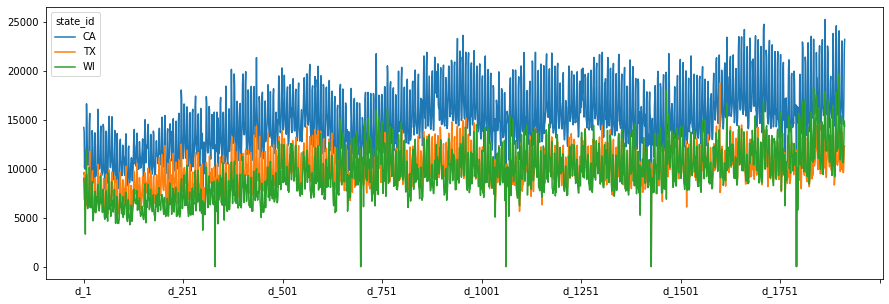

In [91]:
d_cols = [col for col in data_train.columns if 'd_' in col]
data_train.set_index(['state_id'])[d_cols].groupby(by=['state_id']).sum().T.plot(figsize=(15, 5))
# plt.show()
plt.savefig('state_id.png', format='png')

Modeling LSTM

In [ ]:
train = data_train.T
train_name = data_train['id']
train = train[6:]
train.shape

In [22]:
sc = MinMaxScaler(feature_range = (0, 1))
train_df = sc.fit_transform(train)

In [24]:
test = data_eval.T
test_name = data_eval['id']
test = test[6:]
test_df = sc.fit_transform(test)
test.shape

(1941, 30490)

In [25]:
timesteps=28
X_train = []
y_train = []
for i in range(timesteps, 1913):
    X_train.append(train_df[i-timesteps:i])
    y_train.append(train_df[i][0:30490])

In [26]:
X_train = np.array(X_train, dtype = 'float16')
y_train = np.array(y_train, dtype = 'float16')

In [27]:
X_train.shape,y_train.shape

((1885, 28, 30490), (1885, 30490))

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units =64,input_shape = (np.array(X_train).shape[1], np.array(X_train).shape[2])))
model.add(tf.keras.layers.Dense(30490))

model.compile(
  loss='mean_squared_error',
  optimizer=tf.keras.optimizers.Adam(0.001)
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                7822080   
_________________________________________________________________
dense (Dense)                (None, 30490)             1981850   
Total params: 9,803,930
Trainable params: 9,803,930
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train, epochs = 10, batch_size = 10)

Epoch 1/10
189/189 [==============================] - 86s 445ms/step - loss: 0.0156

In [30]:
X_test_vail = []
for i in range(28, 28+28):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test_vail.append(test_df[i-28:i,])
X_test_vail = np.array(X_test_vail)

X_test_eval = []
for i in range(28, 28+28):  # timesteps一樣60； 80 = 先前的60天資料+2017年的20天資料
    X_test_eval.append(train_df[i-28:i,])
X_test_eval = np.array(X_test_eval)

In [31]:
print(X_test_vail.shape)
print(X_test_eval.shape)

(28, 28, 30490)
(28, 28, 30490)


In [32]:
predictions_vail=model.predict(X_test_vail)
predictions_eval=model.predict(X_test_eval)

In [39]:
out_vail = pd.DataFrame(sc.inverse_transform(predictions_vail))
out_vail = out_vail.T
out_vail['id'] = test_name

out_eval = pd.DataFrame(sc.inverse_transform(predictions_eval))
out_eval = out_eval.T
out_eval['id'] = train_name

In [40]:
out = pd.concat([out_vail, out_eval])
print(out.shape)
out.head()

(60980, 29)


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,id
0,0.064738,0.042405,-0.017491,-0.017171,-0.010240,-0.015918,-0.007213,0.048598,0.018864,-0.027833,...,-0.013875,0.011641,0.105229,0.032780,-0.015934,-0.017784,-0.008445,-0.011625,0.024465,HOBBIES_1_001_CA_1_evaluation
1,0.113026,0.035021,-0.127707,-0.088834,-0.120078,-0.103490,-0.090699,0.033174,0.067494,-0.084856,...,-0.126202,-0.098205,0.132932,-0.069018,-0.130023,-0.129021,-0.133295,-0.144911,-0.059903,HOBBIES_1_002_CA_1_evaluation
2,-0.008340,-0.037131,-0.047129,-0.043442,-0.049774,-0.044315,-0.041514,-0.081634,-0.054637,-0.049162,...,-0.045193,-0.053626,-0.030787,-0.032280,-0.048942,-0.048710,-0.046130,-0.040281,-0.043863,HOBBIES_1_003_CA_1_evaluation
3,1.015413,0.908119,0.475401,0.410072,0.420098,0.446626,0.456393,0.601533,0.731475,0.282044,...,0.462979,0.450613,1.076270,0.956117,0.445209,0.456419,0.351651,0.290413,0.525076,HOBBIES_1_004_CA_1_evaluation
4,0.189601,0.105645,-0.314560,-0.232372,-0.266432,-0.268302,-0.249032,0.068629,0.235264,-0.230335,...,-0.257457,-0.167954,0.262374,-0.028956,-0.296816,-0.196598,-0.143526,-0.217811,-0.077109,HOBBIES_1_005_CA_1_evaluation


In [48]:
output = submit[['id']].merge(out, on=['id'])
output.columns = submit.columns
output.shape

(60980, 29)

In [49]:
output.to_csv('./data/output3.csv', index=False)
